TOC
0. [Imports](#first-bullet)
1. [Load Job Descriptions](#1.0-bullet)
2. [Simple Word Count](#2.0-bullet)
3. [Word Significance](#3.0-bullet)
4. [Comparison of Word Vector Analysis](#4.0-bullet)
5. [Topic Analysis](#5.0-bullet)

# <a class="anchor" id="0.0-bullet"> 0. Imports </a>

If any compatability issues arrise, try un-commenting any of the lines below. 

In [1]:
#!pip install docx2txt
#!pip install wordfreq
#!pip install glob
#!pip install wordcloud
#!pip install nltk

In [2]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Document Processing
import glob
import docx2txt

# Text Analysis
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

# <a class="anchor" id="1.0-bullet"> 0. Load Job Descriptions</a>

In [3]:
docs_dict = {}
# Iterate through all files in specified folder and create a dict with valid files
# dict Key/Pair sctucture: [Document Path and Name]:[Text in document] 
# This makes it easier to name each row later, although this is not necessary 
for filepath in glob.iglob('./Data/job_descriptions/*'):
    try: 
        docs_dict[filepath] =  docx2txt.process(filepath)
    except: 
        print('   bad file: ', filepath)

In [4]:
# Create DataFrame from Job descriptions - 1 row per document
df = pd.DataFrame(docs_dict, [0]).T.reset_index()
df.columns = ['title', 'description']
# Strip company information from title according to naming convention
companies_list = []
for element in df.title.str.split(' - '):
    companies_list.append(element[1].replace('.docx', ''))
# Strip company information from title according to naming convention
titles_list = []
for element in df.title.str.split(' - '):
    titles_list.append(element[0].replace("./Data/job_descriptions\\", ''))

df['title'] = titles_list
df['company'] = companies_list
# Just re-arranging columns here for readability
df = df.loc[:, ['company', 'title', 'description']]
# Clean up labels
df.loc[:, 'description'] = df.description.str.replace('\n', ' ')
df.loc[:, 'description'] = df.description.str.replace('  ', ' ')

In [5]:
df.head()

,company,title,description
0,PWC,Analytic Insights,Analytic Insights - Data Scientist Sr Associat...
1,Lithium,Associate Analyst,Job Description Sprefast-Lithium is looking fo...
2,Adlucent,Associate Data Scientist,The Associate Data Scientist will work with ou...
3,Arrive,BI Analyst,Arrive Logistics is seeking a highly-motivated...
4,Indeed,BI Analyst,"Our mission: As the world’s number 1 job site,..."


# <a class="anchor" id="2.0-bullet"> 2. Simple Word Count </a>

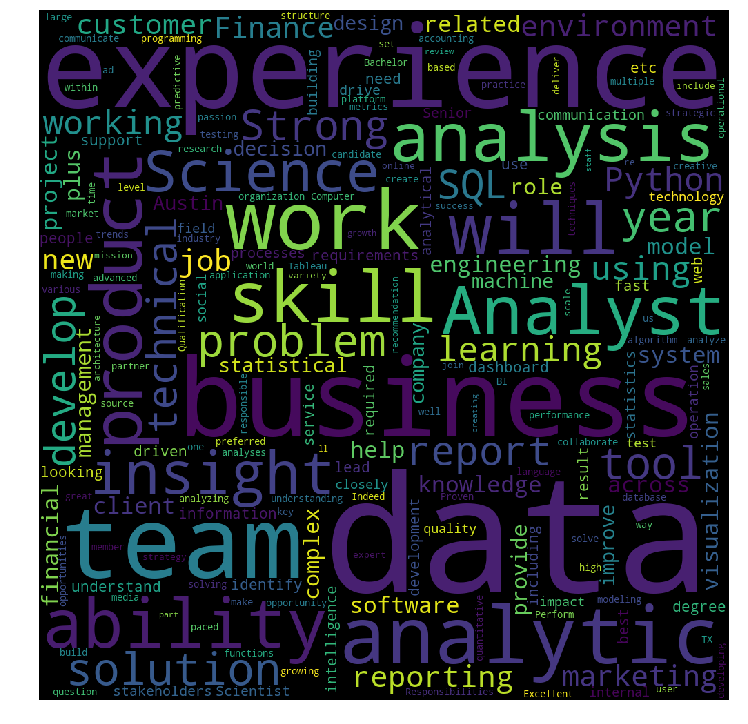

In [12]:
# Word cloud works smoothest with a continuous string
# Add text from all documents to this string
corpus_string = ''
for i in range(df.shape[0]):
    corpus_string = corpus_string + df.iloc[i]['description']

mycloud_2 = WordCloud(width=1000, height=1000, # width / height option. 
                      random_state=42, # If state is not set, re-running the cell will always change the exact layout
                    collocations=False, #get rid of duplicates
                   normalize_plurals=True 
                     ).generate_from_text(corpus_string)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(mycloud_2)
plt.axis("off")
plt.tight_layout(pad = 0)
# Uncomment below to save this figure 
plt.savefig('./my_frequent_words_cloud.jpeg')

In [7]:
# Use copy of whole string from above
corpus_cleaned = corpus_string
# Separate list elements for each word
corpus_list = corpus_cleaned.split(' ')
# Stem and remove stop words to set up useful counts
corpus_list = [PorterStemmer().stem(word) for word in corpus_list if word not in stop_words.ENGLISH_STOP_WORDS]
corpus_cleaned = ' '.join(corpus_list)
# CVEC wants a DataFrame
df_corp = pd.DataFrame(index=[0], columns=['text'])
df_corp.iloc[0,0] = corpus_cleaned

cvec = CountVectorizer()
df_cvec_description = cvec.fit_transform(df_corp['text']).todense()
df_cvec_description = pd.DataFrame(df_cvec_description, columns=cvec.get_feature_names())
df_cvec_description = df_cvec_description.T.reset_index()
df_cvec_description.columns = ['word', 'count']

In [8]:
df_cvec_description.sort_values(by='count', ascending=False)

,word,count
505,data,426
753,experi,184
284,busi,173
2009,team,148
2194,work,143
2211,you,90
118,analyt,89
558,develop,88
1575,product,78
2127,use,72


In [9]:
# As opposed to clean, this version keeps around all words
# Instead of using generalized stemmers, we use our own signficance mapping
# Part of the value of leaving things in like this is to validate the results later
# When we don't see 'and' in the most significant words, we get a fuzzy feeling
# We're on a decent path.
corpus_dirty = corpus_string
corpus_list2 = corpus_dirty.split(' ')

corpus_dirty = ' '.join(corpus_list2)
df_corp2 = pd.DataFrame(index=[0], columns=['text'])
df_corp2.iloc[0,0] = corpus_dirty
cvec2 = CountVectorizer()

df_cvec_description2 = cvec2.fit_transform(df_corp2['text']).todense()
df_cvec_description2 = pd.DataFrame(df_cvec_description2, columns=cvec2.get_feature_names())
df_cvec_description2 = df_cvec_description2.T.reset_index()
df_cvec_description2.columns = ['word', 'count']

In [10]:
df_cvec_description2.sort_values(by='count', ascending=False).head()

,word,count
150,and,1074
2345,to,566
576,data,426
2311,the,376
1577,of,302


# <a class="anchor" id="3.0-bullet"> 3. Word Signficance </a>

## Reddit Corpus
Load in a decent cross-section of words to use for comparison

In [13]:
df_reddit = pd.read_csv('./Data/corpuses_for_baseline/reddit_v1.csv')

In [14]:
# If loading in a new corpus from multiple files, do that here:
# for filepath in glob.iglob('../GA_Projects/project-3/Data/*'):
#    df_reddit = pd.concat([df_reddit, pd.read_csv(filepath)])

In [15]:
cvec_reddit = CountVectorizer()
# Reddit transformed into word count data frame for each post in the corpus
df_reddit_tr = cvec_reddit.fit_transform(df_reddit.title).todense()
df_reddit_tr = pd.DataFrame(df_reddit_tr, columns=cvec_reddit.get_feature_names())

In [16]:
# By definition, CVEC only includes words that appear. 
# A word occurring just once (one reddit) is probably not meaningful and eats memory
# From experience, this is a lot of weird characters or non-English words
lowcount = [col for col in df_reddit_tr if df_reddit_tr[col].sum()==1]
df_reddit_tr.drop(lowcount, axis=1, inplace=True)

In [17]:
# Aggregate counts from all posts for each word
for col in df_reddit_tr.columns:
    df_reddit_tr[col] = df_reddit_tr[col].sum()

counts_reddit = df_reddit_tr.iloc[0:1, :].T

In [18]:
# Relative frequency of all words
freq_reddit = counts_reddit / counts_reddit.sum()
freq_reddit.columns=['global_frequency']

In [19]:
# Join frequency back to dirty count, and remove any words not occurring in the corpus
# May get better results by using cleaned text (df_cvec_description instead of df_cvec_description2)
df_analysis = df_cvec_description2.join(freq_reddit, how='left', on=df_cvec_description2.word)
df_analysis.dropna(inplace=True)
# Weight = significance = count / global frequency
df_analysis['weight'] = df_analysis['count']/df_analysis['global_frequency']

In [20]:
df_analysis.sort_values(by='weight', ascending=False).iloc[:20, :]

,word,count,global_frequency,weight
576,data,426,0.000141,3.012708e+06
1807,product,58,0.000024,2.461085e+06
2033,science,56,0.000024,2.376220e+06
644,develop,42,0.000024,1.782165e+06
1488,models,30,0.000024,1.272975e+06
715,driven,30,0.000024,1.272975e+06
868,experience,201,0.000165,1.218419e+06
2123,skills,71,0.000059,1.205083e+06
1317,learning,42,0.000035,1.188110e+06
32,ability,69,0.000059,1.171137e+06


In [21]:
top_results_to_look_at = 200
df_analysis_short = df_analysis.sort_values(by='weight', ascending=False).iloc[:top_results_to_look_at, :] # Looking at most common only
corp_st = '' 
for i in range(df_analysis_short.shape[0]):
    corp_st += (df_analysis_short.iloc[i,0] + ' ') * df_analysis_short.iloc[i,4] 

mycloud_3 = WordCloud(width=1000, height=1000,random_state=42,
                    collocations=False, #get rid of duplicates
                   normalize_plurals=True).generate_from_text(corp_st)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(mycloud_3)
plt.axis("off")
plt.tight_layout(pad = 0)
# Uncomment below to save this figure 
#plt.savefig('./my_significant_words_cloud.jpeg')

IndexError: single positional indexer is out-of-bounds

I recommend just sort of staring at this picture for your own results and letting it soak in. 

# <a class="anchor" id="4.0-bullet"> 4. Results and Comparison </a>

In [22]:
df_results = df_analysis.sort_values(by='weight', ascending=False).iloc[:15, :].reset_index().drop('index', axis=1).join(
df_cvec_description.sort_values(by='count', ascending=False).iloc[:15,:].reset_index().drop('index', axis=1), rsuffix='_raw_count').loc[:, ['word_raw_count', 'word']]
df_results.columns = ['Basic Count','Word Significance' ]
df_results

,Basic Count,Word Significance
0,data,data
1,experi,product
2,busi,science
3,team,develop
4,work,models
5,you,driven
6,analyt,experience
7,develop,skills
8,product,learning
9,use,ability


The column on the left is the basic count of word stems. On the right is the second methodology, weighting words by relative frequency. 
  
Looking at this table, both versions of the analysis have value. 

The basic count is a quick checklist of must haves in a cover letter or resume. Somewhere, you <u>have</u> to mention team-work, insights, reporting ability, the product.  

What the Word Signficance results start to do is suggest a more natural sentence with real meaning. For example, I can look down the column and see the sentence "Develop data-driven models to improve customer experience and improve product" or "Experience leveraging data science tools to craft financial/marketing analysis". More abstractly, I can see that the job postings in my set are formatted to look for the application of general skills to achieve a result in a specific business area.   
<br>
  
When I go to craft line items for my resume, each bullet can probably safely condensed to read like <br>"Applied <i>skill</i> and knowledge of <i>tool</i> to achieve <i>result</i> in <i>area</i>."  
Each of these generic items can be filled in from a bag of skills I would like to present.  
   
This also gives a framework to condense down vague job postings to identify what the actual ask is. 

# <a class="anchor" id="5.0-bullet"> 5. Topic Analysis </a>